In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import numpy as np 
from pathlib import Path
from hypnose_analysis.utils.metrics_utils import *
from hypnose_analysis.utils.visualization_utils import *
#from utils.visualization_utils import _load_tracking_and_behavior
import harp
from ipywidgets import widgets
from IPython.display import display
import moviepy
%matplotlib widget

# 1. Metrics Visualization

In [3]:
fig, ax = plot_response_times_completed_vs_fa(26, dates=(20250811, 20251010), y_limit=5000)

No data found


In [ ]:
figs = plot_fa_ratio_a_over_sessions(26, dates=(20250811, 20251010))

In [ ]:
fig, axes = plot_abortion_and_fa_rates(40, dates=[20251127], include_noninitiated_in_fa_odor=False, fa_types='FA_time_in,FA_time_out') #can use one or more FA Type filter, or 'All'. E.g., use 'FA_time_in,FA_time_out'

In [7]:
# Plot FA Ratio by Hidden Rule Odor Position
# Can filter by FA types: 'FA_time_in', 'FA_time_out', 'FA_late', or combinations like 'FA_time_in,FA_time_out'
# Can also exclude FAs at a specific position with exclude_last_pos=True (by default set to pos5, can be changed with last_odor_num=x)
fig, axes = plot_fa_ratio_by_hr_position(40, dates=[20251205], fa_types='FA_time_in', print_statistics=True, exclude_last_pos=True)


No data found for FA ratio analysis by HR position


In [ ]:
# Plot FA Ratio by Abortion Odor (comparing HR vs No HR trials)
# Shows FA distribution across aborted sequences grouped by the odor where abortion occurred
fig, axes = plot_fa_ratio_by_abort_odor(40, dates=[20251205], fa_types='FA_time_in')


In [ ]:
fig, axes = plot_sampling_times_analysis(26, dates=(20250916, 20251010))

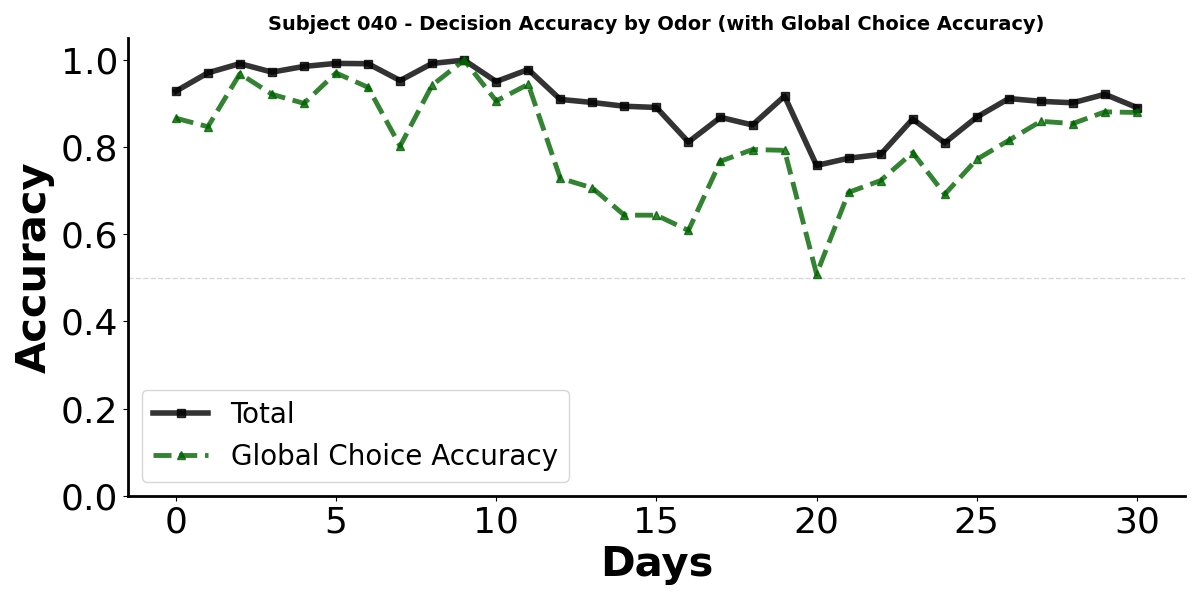

In [28]:
fig, ax = plot_decision_accuracy_by_odor(40, dates=(20251118, 20251231), plot_choice_acc=True, plot_AB=False)

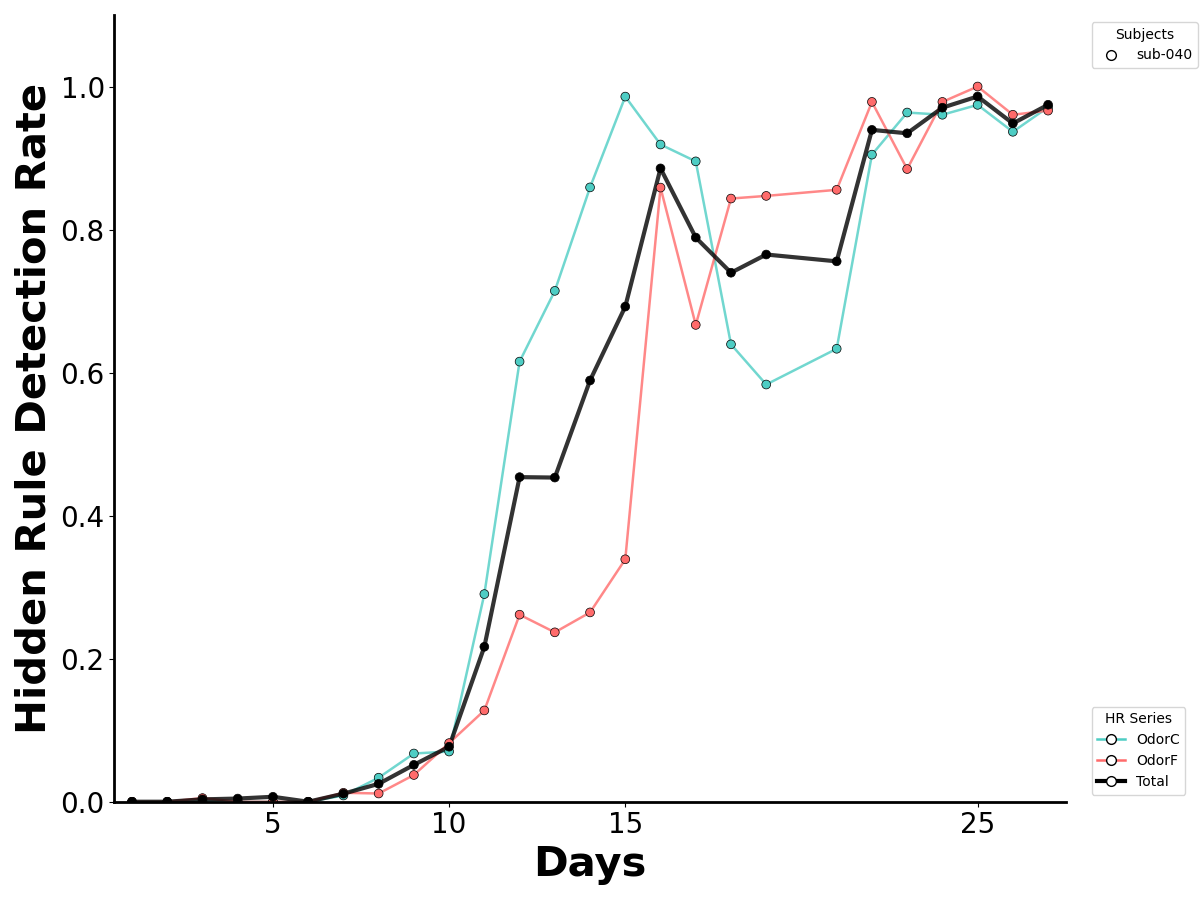

In [6]:
figs = plot_behavior_metrics(
    subjids=[40],
    dates=(20251125, 20251231),
    variables=[
        "hidden_rule_detection_rate",
    ],
    protocol_filter=None,
    compute_if_missing=False, 
    verbose=True, 
    black_white=True, 
    y_range=(0, 1.1), 
    plot_HR_separately=True, 
    show_title=False
)

# 2. Behavior / Movement analysis

In [ ]:
plot_cumulative_rewards(subjids=[37, 38], dates=(20251028, 20251105), split_days=False)

In [ ]:
choice_plots = plot_choice_history(subjid=38, dates=[20251120])

In [ ]:
# modes can be simple (all movement), trial_state (within trial vs outside), last_odor (A vs B), trial_windows (one or more trial windows), time_windows (one or more time windows)
# for trial_windows: trial_windows=[(0, 20), (-20, None)] will plot first vs last 20 trials
# for time_windows: time_windows=[("15:20:00","15:25:00"), ("16:00:00","16:05:00")] will plot 2 5-minute windows
plot_movement_with_behavior(38, 20251030, mode='trial_windows_rew', trial_windows=[(0, 10), (-10,None)], xlim=(220,1160), ylim=(10,950))


In [23]:
plt.close('all')

# Debugging


In [ ]:
# Display detailed FA table for 20251127 OdorF - Total OdorF
# This shows all individual FA events with timestamps, types, ports, and positions
import json

subjid = 40
target_date = 20251126
target_odor = 'OdorC'
target_category = f'Total {target_odor}'

base_path = Path(project_root) / "data" / "rawdata"
server_root = base_path.resolve().parent
derivatives_dir = server_root / "derivatives"

# Find the session for the target date
fa_detail_rows = []
from utils.visualization_utils import _iter_subject_dirs, _filter_session_dirs
for sid, subj_dir in _iter_subject_dirs(derivatives_dir, [subjid]):
    ses_dirs = _filter_session_dirs(subj_dir, (target_date, target_date))
    
    for session_num, ses in enumerate(ses_dirs, 1):
        date_str = ses.name.split("_date-")[-1]
        results_dir = ses / "saved_analysis_results"
        
        if not results_dir.exists():
            continue
        
        hr_path = results_dir / "aborted_sequences_HR.csv"
        ab_det_path = results_dir / "aborted_sequences_detailed.csv"
        summary_path = results_dir / "summary.json"
        
        if not hr_path.exists() or not ab_det_path.exists() or not summary_path.exists():
            continue
        
        try:
            # Load data
            with open(summary_path) as f:
                summary = json.load(f)
            
            hr_odors = summary.get("params", {}).get("hidden_rule_odors", [])
            if target_odor not in hr_odors:
                continue
            
            df_hr = pd.read_csv(hr_path)
            df_ab = pd.read_csv(ab_det_path)
            
            # Match HR trials with aborted sequences
            if "sequence_start" not in df_hr.columns or "sequence_start" not in df_ab.columns:
                continue
            
            hr_with_fa = df_hr[df_hr["sequence_start"].isin(df_ab["sequence_start"])].copy()
            
            # Merge to get FA details
            merged = hr_with_fa.merge(
                df_ab[["sequence_start", "fa_label", "last_odor_name", "fa_port", "last_odor_position"]],
                on="sequence_start",
                how="left"
            )
            
            # Add HR position info
            hr_cols_to_merge = ["sequence_start"]
            if "hidden_rule_positions" in df_hr.columns:
                hr_cols_to_merge.append("hidden_rule_positions")
            
            if len(hr_cols_to_merge) > 1:
                merged = merged.merge(
                    df_hr[hr_cols_to_merge],
                    on="sequence_start",
                    how="left",
                    suffixes=('', '_hr')
                )
            
            # Filter for actual FAs (not nFA) - exclude FA_late
            merged_fa = merged[(merged["fa_label"] != "nFA") & (merged["fa_label"] != "FA_late")].copy()
            
            if merged_fa.empty:
                continue
            
            # Helper functions
            def get_hr_position(hr_pos_str):
                if pd.isna(hr_pos_str):
                    return None
                try:
                    pos_list = json.loads(str(hr_pos_str))
                    if isinstance(pos_list, list) and len(pos_list) > 0:
                        return int(pos_list[0])
                except:
                    pass
                return None
            
            # Filter for target odor
            for odor_num, hr_odor in enumerate(hr_odors, 1):
                if hr_odor != target_odor:
                    continue
                
                # Filter to trials where this HR odor appears
                if "odor_sequence" in merged_fa.columns:
                    def has_hr_odor(odor_seq, target_hr):
                        if pd.isna(odor_seq):
                            return False
                        try:
                            seq_list = json.loads(str(odor_seq))
                            return target_hr in seq_list if isinstance(seq_list, list) else False
                        except:
                            return target_hr in str(odor_seq)
                    
                    fa_for_this_hr = merged_fa[
                        merged_fa["odor_sequence"].apply(lambda seq: has_hr_odor(seq, hr_odor))
                    ].copy()
                else:
                    fa_for_this_hr = merged_fa.copy()
                
                if fa_for_this_hr.empty:
                    continue
                
                # Extract HR position
                fa_for_this_hr["hr_position"] = fa_for_this_hr["hidden_rule_positions"].apply(get_hr_position)
                fa_for_this_hr = fa_for_this_hr[fa_for_this_hr["hr_position"].notna()]
                
                # Get Total FAs (at or after HR position)
                fa_total = fa_for_this_hr[
                    (fa_for_this_hr["last_odor_position"] >= fa_for_this_hr["hr_position"])
                ].copy()
                
                if not fa_total.empty:
                    # Build detail table
                    for idx, row in fa_total.iterrows():
                        # Map port number to name
                        port_name = "Port A" if row["fa_port"] == 1 else "Port B" if row["fa_port"] == 2 else "Unknown"
                        
                        fa_detail_rows.append({
                            "Seq Start Time": row.get("sequence_start", "N/A"),
                            "FA Type": row.get("fa_label", "N/A"),
                            "FA Port": port_name,
                            "Last Odor Pos": int(row.get("last_odor_position", -1)) if pd.notna(row.get("last_odor_position")) else "N/A",
                        })
        
        except Exception as e:
            print(f"Error processing date {date_str}: {e}")
            continue

# Display the table
if fa_detail_rows:
    df_detail = pd.DataFrame(fa_detail_rows)
    
    # Print formatted table
    print("="*100)
    print(f"Detailed FA Information for {target_date} {target_category}")
    print("="*100)
    print(f"{'Seq Start Time':<35} {'FA Type':<20} {'FA Port':<12} {'Last Odor Pos':<15}")
    print("-" * 100)
    
    for idx, row in df_detail.iterrows():
        print(f"{str(row['Seq Start Time']):<35} {str(row['FA Type']):<20} {str(row['FA Port']):<12} {str(row['Last Odor Pos']):<15}")
    
    print()
    print(f"Total FA count: {len(df_detail)}")
else:
    print(f"No FA data found for {target_date} {target_category}")
